# Customer Churn Prediction with IBM Db2 using PySpark

__Introduction__

This notebook presents a churn prediction use case using anonymized customer data from a phone operator. It uses IBM Db2 Warehouse and runs on a PySpark kernel. Some visualizations are plotted locally using seaborn and matplotlib.

Our goal is to accurately predict whether a customer is going to end his/her contract (labeled as positive/1). Since we prefer to send a commercial email to someone who intends to keep her contract but is labeled as willing to end it (false positive) rather than to overlook the opportunity to prevent a customer from ending her contract (false negative), our optimization objective will be to minimize the false negative rate. We will also look at other classic metrics too.

__Contents__
1. Get ready
2. Explore the data
3. Select and create features 
4. Train different algorithms
5. Fine tune your hyperparameters on the validation set
6. Assess your model performance on the test set


Conclusion


## 1. Get ready

__Imports__

Import the necessary Spark classes, as well as Python packages for local visualisations.
We will plot the graphs directly in this notebook. If you like to plot them in a separate window, just comment out `%matplotlib inline`.

In [1]:
# Useful imports - PySpark
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%local
%matplotlib inline

# Useful imports for local visualisations

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import polyfit
from sklearn import metrics
from sklearn.metrics import classification_report

__Load the data__

Let's use a table which has been pre-populated in Db2 local. It is called SAMPLES.TRAINING. 

In [3]:
sparkSession = SparkSession \
        .builder \
        .getOrCreate()

df = sparkSession.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable="SAMPLES.TRAINING") \
        .load()
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|CHURN|AREA|VMAIL|VMAIL_MSGS|DAY_MINS|DAY_CALLS|DAY_CHARGE|EVE_MINS|EVE_CALLS|EVE_CHARGE|NIGHT_MINS|NIGHT_CALLS|NIGHT_CHARGE|INTL_MINS|INTL_CALLS|INTL_CHARGE|SVC_CALLS|
+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|    0| 415|    1|         0|   246.5|      108|     41.91|   216.3|       89|     18.39|     179.6|         99|        8.08|     12.7|         3|       3.43|        2|
|    1| 408|    1|         0|   298.1|      112|     50.68|   201.3|      100|     17.11|     214.7|         88|        9.66|      9.7|         4|       2.62|        2|
|    0| 510|    1|         0|   119.3|       82|     20.28|   185.1|      111|     15.73|     157.0|         74|        7.07|     10.9|         4|       2.

How many records do we have? How many features?

In [4]:
print('Number of records: '+str(df.count()))
print('Number of features: '+str(len(df.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of records: 3333
Number of features: 17

__Split the data__

We split the data into three datasets: for training, validation and testing. We use the proportions 90%, 5% and 5% so that we keep a relatively high number of examples for training. Of course these proportions are subjective, you can change them if you want. We have defined a seed so tht results can be reproduced.

In [5]:
train, val, test = df.randomSplit([0.85,0.10,0.05],1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Explore the data

Of course we only explore the training data because we are not allowed to look at validation and test data during the training phase.

__Data schema__

In [6]:
train.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- CHURN: short (nullable = false)
 |-- AREA: integer (nullable = false)
 |-- VMAIL: short (nullable = false)
 |-- VMAIL_MSGS: integer (nullable = false)
 |-- DAY_MINS: decimal(5,1) (nullable = false)
 |-- DAY_CALLS: integer (nullable = false)
 |-- DAY_CHARGE: decimal(5,2) (nullable = false)
 |-- EVE_MINS: decimal(5,1) (nullable = false)
 |-- EVE_CALLS: integer (nullable = false)
 |-- EVE_CHARGE: decimal(5,2) (nullable = false)
 |-- NIGHT_MINS: decimal(5,1) (nullable = false)
 |-- NIGHT_CALLS: integer (nullable = false)
 |-- NIGHT_CHARGE: decimal(5,2) (nullable = false)
 |-- INTL_MINS: decimal(4,1) (nullable = false)
 |-- INTL_CALLS: integer (nullable = false)
 |-- INTL_CHARGE: decimal(4,2) (nullable = false)
 |-- SVC_CALLS: integer (nullable = false)

Columns include:

- Churn : whether the customer resigned his/her phone subscription, this is our target
- Area : a geographic label, we might wonder which impact this feature has on churn
- VMail: whether voice messages have been left
- VMail_msgs: number of voice messages
- day_mins, eve_mins, night_mins, intl_mins: time spend calling in the day/evening/night/abroad
- day_calls, eve_calls, night_calls, intl_calls: number of calls in each category
- day_charge, eve_charge, night_charge, intl_charge: price charged for each category
- svc_calls: service calls.

__A few statistics__

In [7]:
train.describe().toPandas().transpose()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                  0                    1                    2     3      4
summary       count                 mean               stddev   min    max
CHURN          2816  0.14595170454545456   0.3531204965103387     0      1
AREA           2816         437.86328125    42.73642779281718   408    510
VMAIL          2816   0.7169744318181818  0.45054875645071607     0      1
VMAIL_MSGS     2816           8.26171875   13.761584666502015     0     51
DAY_MINS       2816            179.54286    53.90882895138431   0.0  350.8
DAY_CALLS      2816   100.52308238636364   19.940217041108056     0    165
DAY_CHARGE     2816            30.522841     9.16444798178894  0.00  59.64
EVE_MINS       2816            201.63242    50.46572784917858   0.0  354.2
EVE_CALLS      2816   100.16051136363636   19.910880027473244     0    170
EVE_CHARGE     2816            17.138981   4.2895736113634095  0.00  30.11
NIGHT_MINS     2816            200.72773    50.57654629518817  23.2  395.0
NIGHT_CALLS    2816   100

We see that there is no missing value in the dataset, which is great. 

We have a turnout of roughly 15%, so __we must do better than a 85% accuracy__ (accuracy of a naive classifier which would label all examples as 0 id est customer remains a client).

__Visualisation__

Let's answer the following questions thanks to visualizations: What relationships do exist between features? How are features correlated to churn? What is the average price per minute? Are there outliers?

*Pull data locally for visualisation*

In [8]:
train.createOrReplaceTempView('train')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
%%sql -o train --maxrows -1
SELECT * FROM train

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

__Explore relationships between features with a scatter plot__


NB: Color code is blue if CHURN is 0, red if CHURN is 1.

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



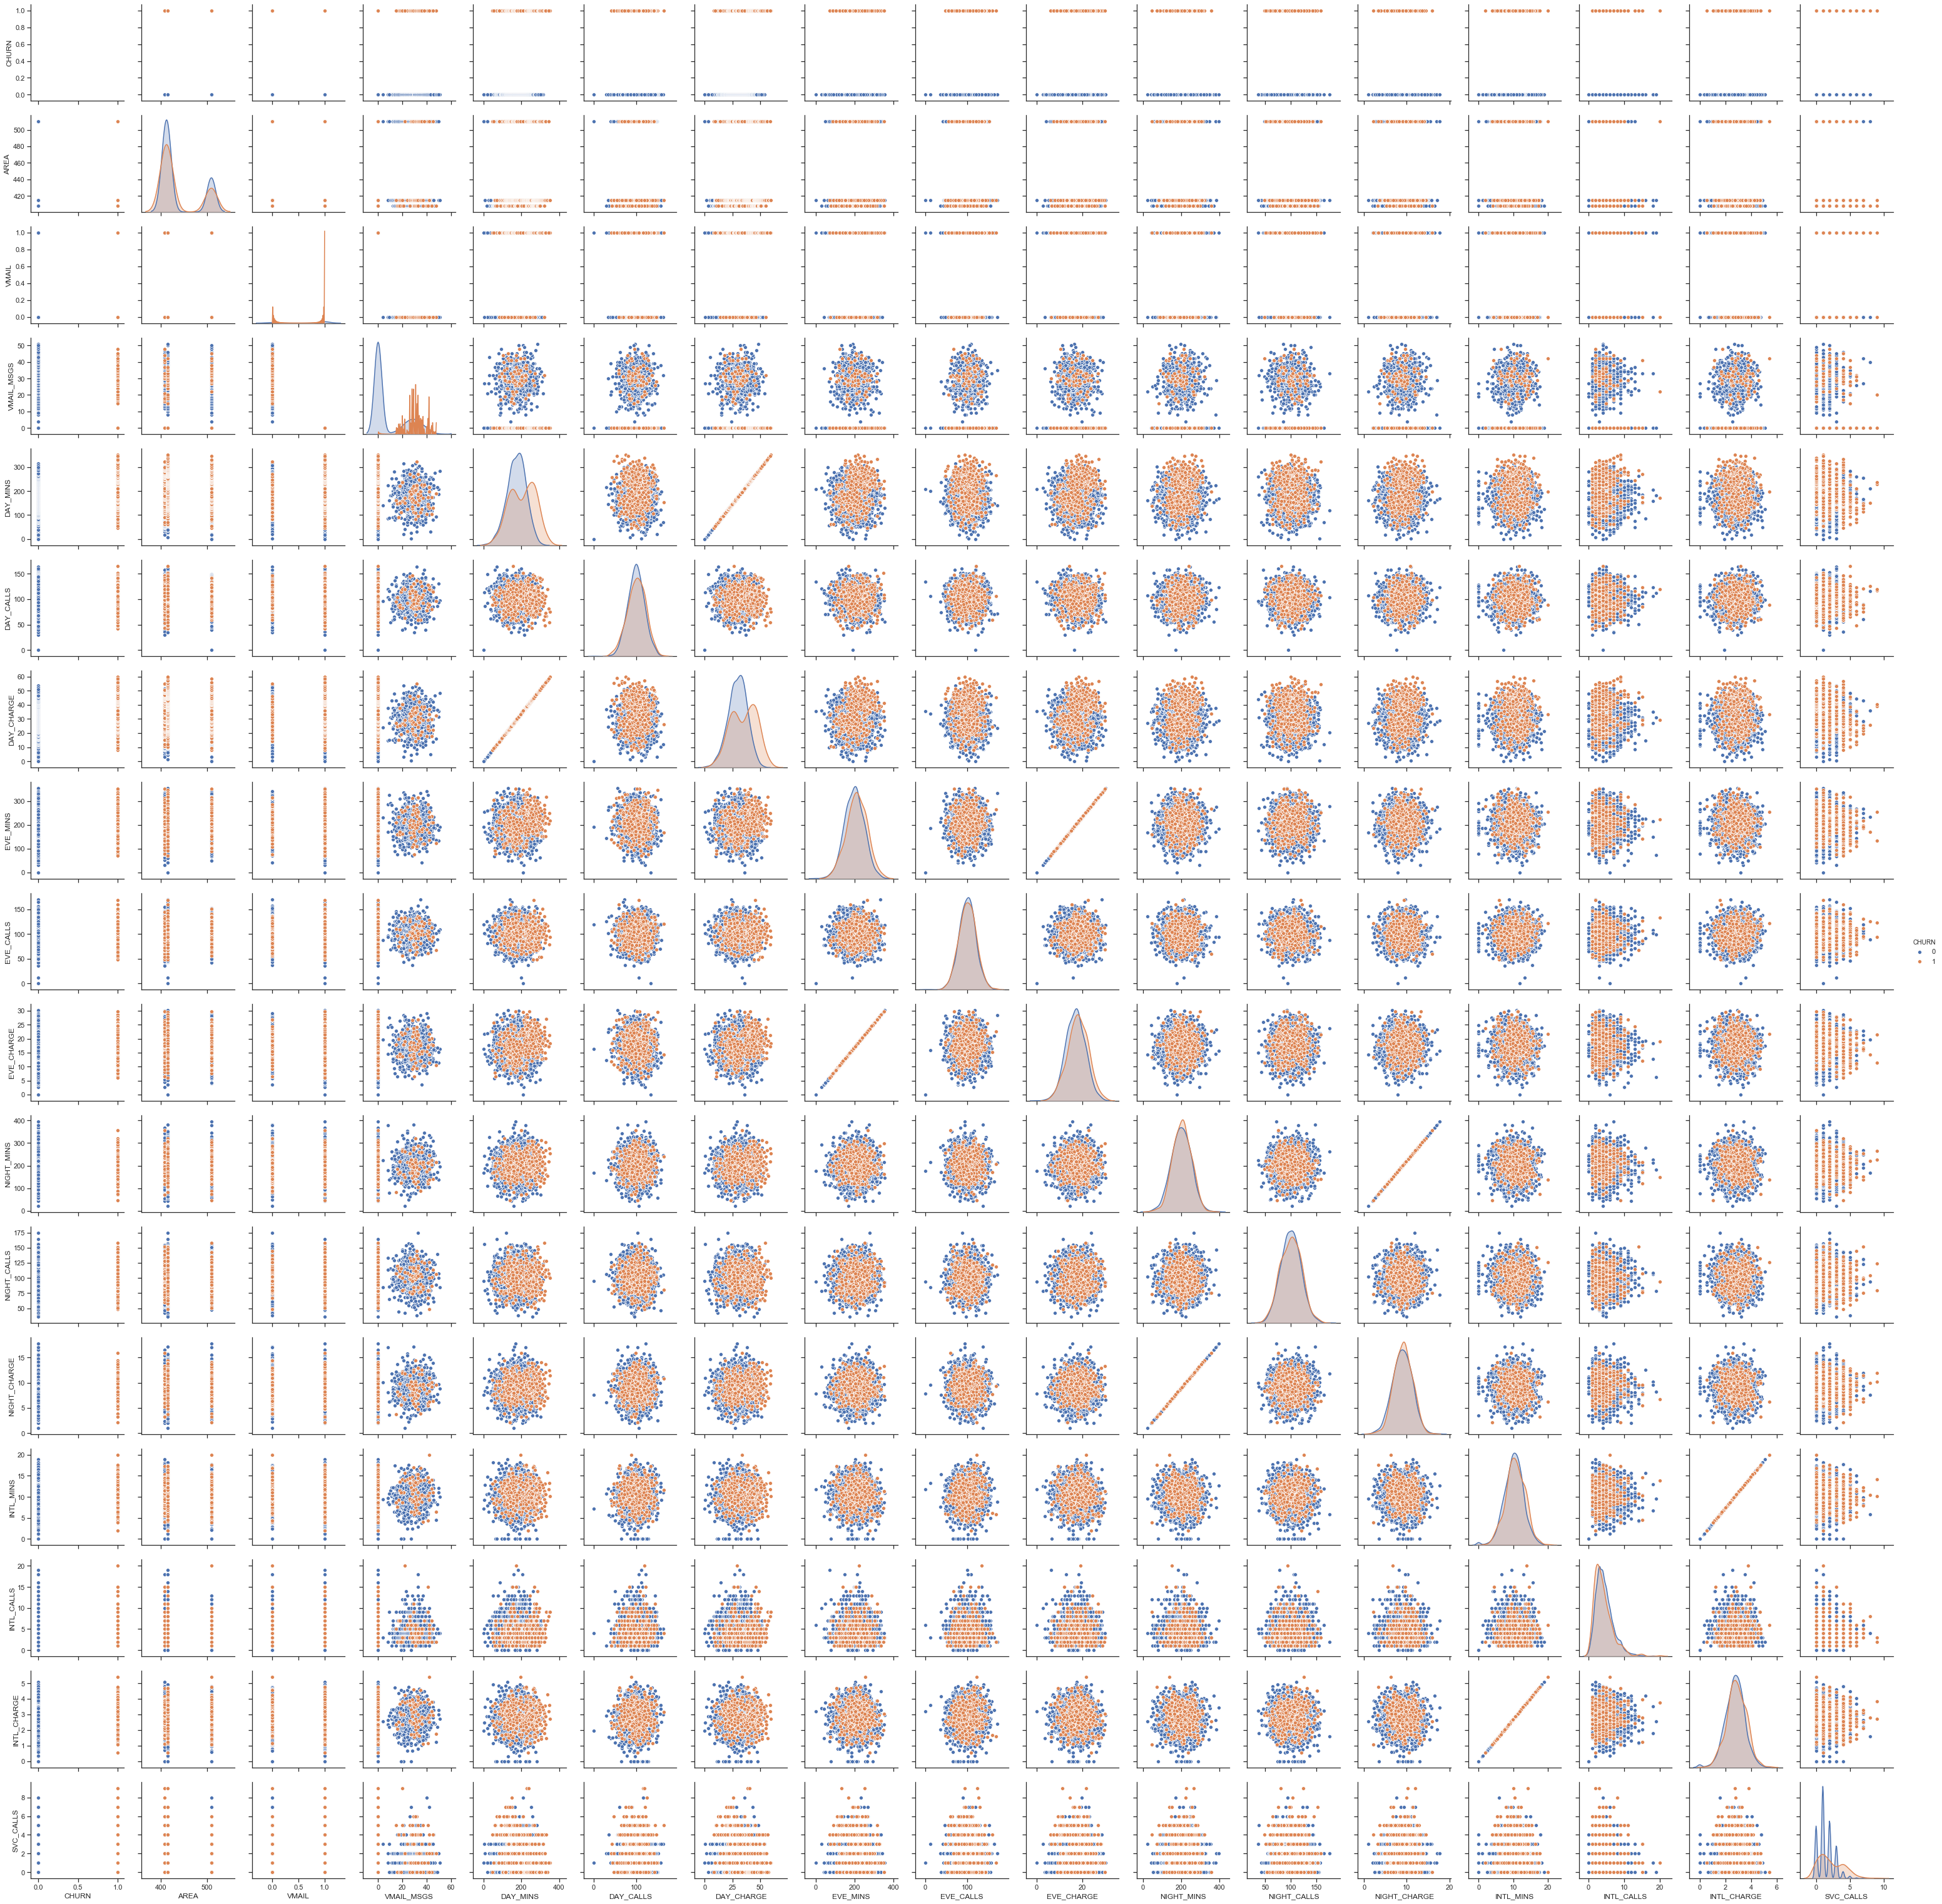

In [10]:
%local

sns.set(style="ticks")

sns.pairplot(train, hue='CHURN')


Comments
- most people who have voice mail messages are likely to end their contract, particulrly if they receive between 20 and 40 voice messages.
- distribution of number of calls and cumulated time among each category is very similar between classes churn=1 and churn=0. This might make our prediction task hard to perform.
- service calls distributions however differ from class 0 to class 1. They also all come from the same area.
- concentric round patterns tend to appear but the red zone is superimposed with the blue underlying zone, so this might also make prediction hard.
- pricing seems to be linear (simple linear function between time and price, no flat rate or minimum charge).


__Find out the price per minute with a linear regression__

In the previous section we could see that a linear function seems to map the time spent on the phone to the price actually charged. Let's perform a linear regression to compute the average price per minute. We take the example of phone calls made during day time, the same method can be applied to the other categories. We can also compare prices between categories.

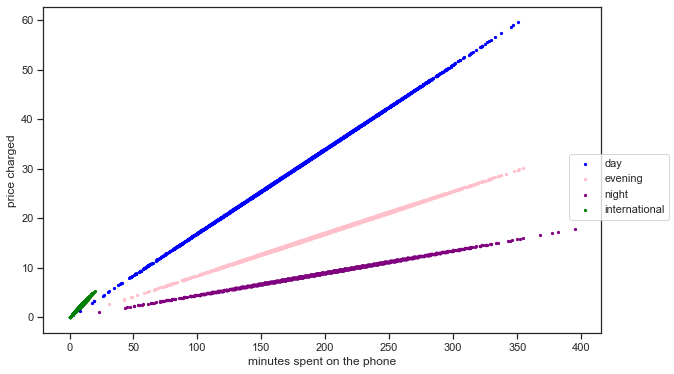

In [11]:
%local

# Price charged per minute

ax, fig=plt.subplots(figsize=(10,6))

plt.scatter(train['DAY_MINS'], train['DAY_CHARGE'], color='blue', s=5, label='day')
plt.scatter(train['EVE_MINS'], train['EVE_CHARGE'], color='pink', s=5, label='evening')
plt.scatter(train['NIGHT_MINS'], train['NIGHT_CHARGE'], color='purple', s=5, label='night')
plt.scatter(train['INTL_MINS'], train['INTL_CHARGE'], color='green', s=5, label='international')


plt.xlabel('minutes spent on the phone')
plt.ylabel('price charged')

ax.legend(loc='right')

plt.show()

International calls are more expensive. A higher price is charged during the day than during the evening and the night. It seems that for each call type, a linear pricing is applied. Let's confirm this intuition by building a linear regression model and computing the error on separate data.

First, be have to prepare the data so that it is in the format [feature, label] required by the dedicated PySpark functions.

In [12]:
# Data preparation

#Select necessary features DAY_MINS (input feature) and DAY_CHARGE (target feature or label)
data_DAY = train.select(train.DAY_MINS, train.DAY_CHARGE)
# Check the schema
print('Schema of data_DAY')
data_DAY.printSchema()

# Split data in a training and a testing set in order to assess the quality of our regression
train_DAY, test_DAY = data_DAY.randomSplit([0.7,0.3])

# Define the vector assembler you need for this linear regression
DAY_assembler = VectorAssembler().setInputCols(['DAY_MINS',]).setOutputCol('features')

# Transform the datasets according to this assembler
train01 = DAY_assembler.transform(train_DAY)
test01 = DAY_assembler.transform(test)
# Check the schema: a new column has been created
print("Schema of train01")
train01.printSchema()

# Rename the DAY_CHARGE column to label and select omly the label and features column
train02 = train01.select(train01["features"], train01["DAY_CHARGE"].alias("label"))
test02 = test01.select(test01["features"], test01["DAY_CHARGE"].alias("label"))
# Check how your data looks like
print("Data lookup: train02")
train02.show(5, truncate=False)

# we need to have the keywords features, label and prediction as column names

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Schema of data_DAY
root
 |-- DAY_MINS: decimal(5,1) (nullable = false)
 |-- DAY_CHARGE: decimal(5,2) (nullable = false)

Schema of train01
root
 |-- DAY_MINS: decimal(5,1) (nullable = false)
 |-- DAY_CHARGE: decimal(5,2) (nullable = false)
 |-- features: vector (nullable = true)

Data lookup: train02
+--------+-----+
|features|label|
+--------+-----+
|[0.0]   |0.00 |
|[2.6]   |0.44 |
|[7.8]   |1.33 |
|[17.6]  |2.99 |
|[18.9]  |3.21 |
+--------+-----+
only showing top 5 rows

Define the model characteristics and fit the model to your training set.

In [13]:
lr = LinearRegression(featuresCol="features", labelCol="label",maxIter=10, regParam=0.3, elasticNetParam=0.8)
LRmodel = lr.fit(train02)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Compute training error: Regression coefficient R2 and RMSE

In [14]:
train03 = LRmodel.transform(train02)
train04 = train03.select(train03["features"], train03["label"], train03["prediction"])

evaluator = RegressionEvaluator()
print("R^2: %f" % evaluator.evaluate(train04,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(train04,{evaluator.metricName: "rmse"}))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

R^2: 0.998953
RMSE: 0.298072

Compute error on test set

In [15]:
test03 = LRmodel.transform(test02)
test04 = test03.select(test03["features"], test03["label"], test03["prediction"])
test04.show(5, truncate=False)

evaluator = RegressionEvaluator()
print("R^2: %f" % evaluator.evaluate(test04,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(test04,{evaluator.metricName: "rmse"}))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-----+------------------+
|features|label|prediction        |
+--------+-----+------------------+
|[141.8] |24.11|24.316591707403184|
|[134.2] |22.81|23.066406898544166|
|[151.1] |25.69|25.84642311824382 |
|[198.8] |33.80|33.69297777384579 |
|[236.3] |40.17|39.86165281755803 |
+--------+-----+------------------+
only showing top 5 rows

R^2: 0.998950
RMSE: 0.301202

R is the regression coefficient. R² value ~ 1 is a good fit. This confirm the impression we got from visualization: we can assume from now that a linear function  maps day call minutes to day charge. It's the same for the other categories. 

The Root Mean Square Error (RMSE) has to be compared to the actual magnitude of the phenomenon. In our case, it is low compared to the mean DAY_CHARGE value (30.56) and its standard deviation (9.24).

Price per minute

In [16]:
# Print the coefficients for linear regression
print("Coefficients: %s" % str(LRmodel.coefficients))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Coefficients: [0.16449800116565977]

So one minute of phone call at daytime approximtely costs 0.16 dollars.

Finally, we can plot the curve with the points.

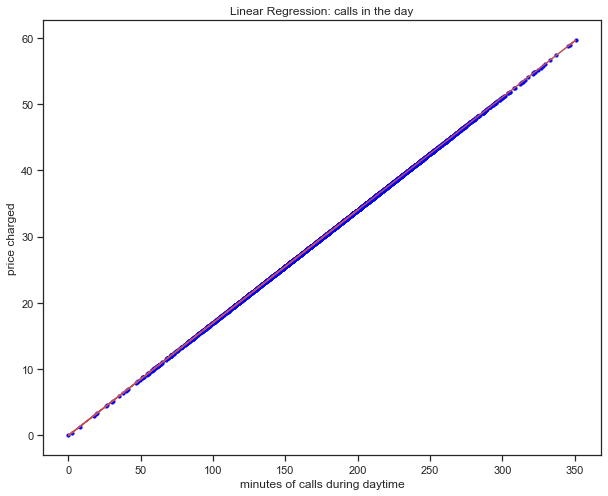

In [17]:
%local

plt.figure(figsize=(10,8))

x1 = train['DAY_MINS'].astype('float').values.tolist()
y1 = train['DAY_CHARGE'].astype('float').values.tolist()
plt.scatter(x1, y1, color='blue', s=10)
plt.xlabel('minutes of calls during daytime')
plt.ylabel('price charged')
plt.title('Linear Regression: calls in the day')

p1 = polyfit(x1, y1, 1)
plt.plot(x1, np.polyval(p1,x1), 'r-' )

plt.show()

__Customer churn and phoning habits__

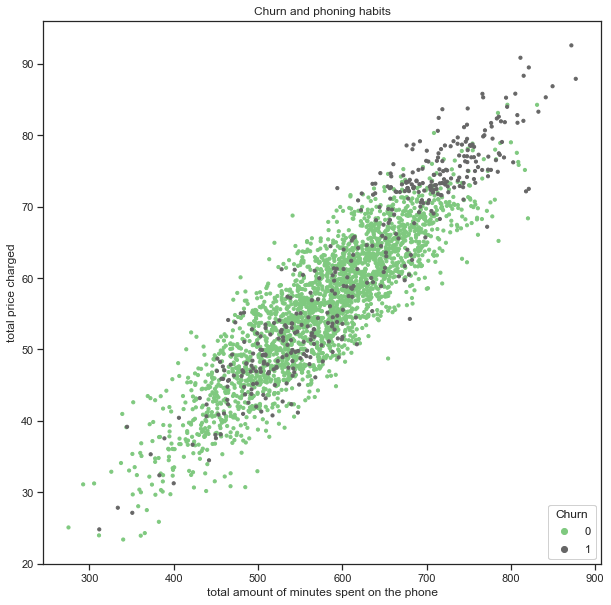

In [18]:
%local

#total amount of time spent on the phone
tot_mins=train['DAY_MINS']+train['EVE_MINS']+train['NIGHT_MINS']

#total price charged
tot_charge=train['DAY_CHARGE']+train['EVE_CHARGE']+train['NIGHT_CHARGE']


# Plot

x, y = tot_mins, tot_charge
c = train['CHURN']

fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(x, y, c=c, s=10, cmap='Accent')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Churn")
ax.add_artist(legend1)

plt.xlabel('total amount of minutes spent on the phone')
plt.ylabel('total price charged')

plt.title('Churn and phoning habits')
plt.savefig('churn')
plt.show()

There seem to be a cluster of people who ended their contract and used the service more than others. People who resigned their contract tend to be charged more than others because they have a high consumption, or to have a middle/low range consumption (which does not allow us to tell them apart from the others for now). There could be two customer clusters as drawn here:

<img src="churn.png"/>

__Correlation matrix__

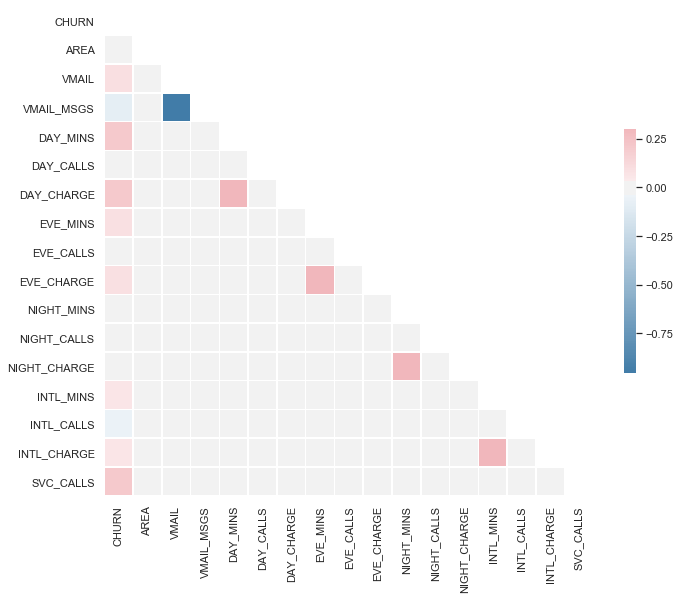

In [19]:
%local

sns.set(style="white")

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
# Since the matrix is symmetric, wejust need one half of the coefficients
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


Features tend not to be very correlated! 

A positive correlation between two features means that the two phenomenons tend to grow together.

Here are the factors that seem to encourage a customer to end his/her contract:

Particularly:
* time spent on the phone in the day
* service calls

And then:
* time spent on international calls
* having voice mail messages (y/n)

Factors that encourage a customer not to end a contract:
* number of voice mail messages received (!)
* number of international calls made.

Additionaly, we can again observe the linear relation we had alreay discovered between time spent on the phone and price charged appears here on the correlation matrix for each type of call. We will therefore delete redundant columns in the next steps of this notebook.

## 3. Select and create features

__Feature selection__ (?) -> feature importance !

__Create new columns__ (?)

In [20]:
TOT_MINS = train['DAY_MINS']+train['EVE_MINS']+train['INTL_MINS']+train['NIGHT_MINS']
# type <class 'pyspark.sql.column.Column'>

new_train = train.withColumn("TOT_MINS", TOT_MINS)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 4. Train different algorithms 

KMeans, logistic regression, decision trees

### a. Apply unsupervised learning for customer segmentation with kMeans

Create a model: Build a Spark ML algorithm that selects the call counts from the customer data and clusters them using KMeans.

In [21]:
# Version 1 -> only 4 columns used: "INTL_CALLS", "DAY_CALLS", "EVE_CALLS", "NIGHT_CALLS"
# Version 2 -> "INTL_CALLS", "DAY_CALLS", "EVE_CALLS", "NIGHT_CALLS", "SVC_CALLS", "INTL_CHARGE", "DAY_CHARGE", "EVE_CHARGE", "NIGHT_CHARGE"],
# Version 3 -> + "VMAIL_MSGS", "VMAIL"
# On which data to train
assembler = VectorAssembler(
    inputCols=["VMAIL_MSGS", "VMAIL", "INTL_CALLS", "DAY_CALLS", "EVE_CALLS", "NIGHT_CALLS", "SVC_CALLS", "INTL_CHARGE", "DAY_CHARGE", "EVE_CHARGE", "NIGHT_CHARGE"],
    outputCol="features")
newDF = assembler.transform(train)

# Set characteristics of your model 
kmeans = KMeans().setK(10).setSeed(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Fit the model to the required training set and run the algorithm to find the clusters.

In [22]:
model = kmeans.fit(newDF)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Print out the cluster centers.

In [23]:
predictions = model.transform(newDF)
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cluster Centers: 
[  5.06530612   0.81632653   4.51836735 108.79183673  74.42040816
  80.91836735   1.62857143   2.73853061  29.61097959  17.42367347
   9.0964898 ]
[  0.50783699   0.97178683   4.36050157  78.49529781 109.27899687
  89.65203762   1.61755486   2.78100313  29.91918495  17.49442006
   8.94623824]
[ 31.74796748   0.           4.59349593 115.99186992  95.32113821
 106.81300813   1.5          2.8195122   30.50028455  17.14817073
   9.19203252]
[  4.64122137   0.81679389   4.63358779 107.50763359 131.14122137
 106.26717557   1.51526718   2.83618321  30.78958015  16.87583969
   8.93790076]
[ 31.74900398   0.           4.4501992   87.62151394 107.47410359
  92.27888446   1.48207171   2.79613546  31.03243028  17.20390438
   9.17358566]
[ 6.86607143  0.73660714  4.58482143 75.33035714 78.58482143 98.25
  1.51339286  2.80763393 32.03745536 17.08098214  8.9090625 ]
[  0.21084337   0.98493976   4.36445783 125.          99.01204819
 107.59036145   1.5          2.80021084  31.72328313

__Inference__

KMeans is an unsupervized learning algorithm: we have to see if the clusters we have just built can be used to infer churn!

In [24]:
# Number of customers in each cluster
predictions.groupBy("prediction").count().sort("count").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|prediction|count|
+----------+-----+
|         5|  225|
|         0|  243|
|         2|  245|
|         4|  251|
|         3|  262|
|         8|  273|
|         1|  322|
|         7|  330|
|         6|  332|
|         9|  333|
+----------+-----+

In [25]:
# Churn proportion in each cluster
predictions.groupBy("prediction").avg("CHURN").sort("avg(CHURN)").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------------+
|prediction|         avg(CHURN)|
+----------+-------------------+
|         2|0.08163265306122448|
|         4|0.10358565737051793|
|         8|0.13186813186813187|
|         7| 0.1393939393939394|
|         9|0.14414414414414414|
|         3| 0.1450381679389313|
|         5|0.16444444444444445|
|         0|0.17695473251028807|
|         1|0.17701863354037267|
|         6|0.18072289156626506|
+----------+-------------------+

__Result analysis__

For a 90/5/5 split

Version 1

* Case k=3 : Not useful to infer churn! the proportion of customers which will end their contract is similar among clusters and approximately the same as the probability of the training set.

* Case k=10: More differences between clusters, churn proportions vary between 0.118 and 0.187 but it's not precise enough to label a cluster as having a particularly high or low churn probability. 

Version 2 (more features)

* Case k=10: churn percentage between 0.108 and 0.197. A bit better but still not enough to tell if a customer must be targeted or not. However, marketing campaigns can be directed towards customers belonging to the clusters with the highest churn probability.

Version 3 (all features)
* Case k=10: 0.094 to 0.185, idem.

For a 85/10/5 split
* Case k=10: 0.0816 to 0.181, idem.

We should try to implement a supervised learning model to be more accurate.

### b. Apply supervised learning for churn prediction with logistic regression

__Prepare the data__

Select columns and set label names for training

In [26]:
# Define the set of columns you want to use for training
LogReg_assembler = VectorAssembler().setInputCols(["INTL_CALLS", "DAY_CALLS", "EVE_CALLS", "NIGHT_CALLS", "SVC_CALLS", 
                                                   "INTL_CHARGE", "DAY_CHARGE", "EVE_CHARGE", "NIGHT_CHARGE",
                                                   "VMAIL_MSGS", "VMAIL"]).setOutputCol("features")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Transform your training set
assembled_train = LogReg_assembler.transform(train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# Select only the label and features columns
labeled_train = assembled_train.select(assembled_train["features"], assembled_train["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
# Take a look at the data
labeled_train.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[5.0,76.0,105.0,9...|    0|
|[4.0,104.0,98.0,9...|    0|
|[3.0,65.0,77.0,95...|    0|
|[2.0,81.0,103.0,1...|    0|
|[5.0,110.0,120.0,...|    0|
+--------------------+-----+
only showing top 5 rows

__Build your model__

In [30]:
# Define your model
logReg = LogisticRegression(maxIter=20)

# Fit the model
logRegModel = logReg.fit(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Visualize feature importance__

In [31]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(logRegModel.coefficients))
print("Intercept: " + str(logRegModel.intercept))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Coefficients: [-0.07162044882692284,-0.0017810099552226222,-0.004650456295226493,-0.005407463825295629,0.4593201036165997,0.19074613141156863,0.06817800206569095,0.04792862779215292,0.015279650457790837,-0.05692624928699032,-1.135252421472247]
Intercept: -3.571226319722783

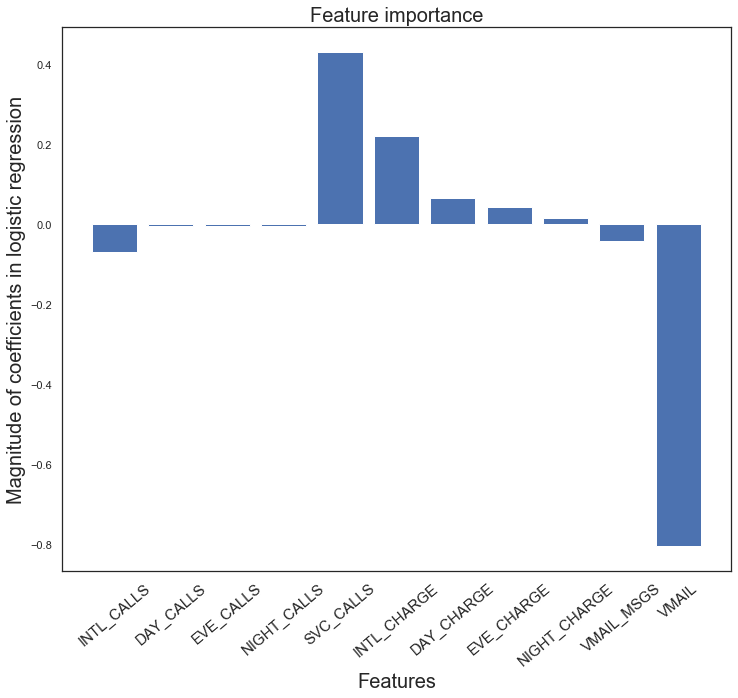

In [32]:
%local

#copy paste new coeffs list if necessary

features=["INTL_CALLS", "DAY_CALLS", "EVE_CALLS", "NIGHT_CALLS", "SVC_CALLS", 
          "INTL_CHARGE", "DAY_CHARGE", "EVE_CHARGE", "NIGHT_CHARGE",
          "VMAIL_MSGS", "VMAIL"]
coeffs=[-0.06916602014895208,-0.003119256565889928,-0.004227270875708172,-0.004632854057081005,
         0.4311738520153244,0.219956167813764,0.06512723006582327,0.0436753538628841,
         0.016765712663125515,-0.042954331397127135,-0.8055223654450755]

ax, fig=plt.subplots(figsize=(12,10))
index = np.arange(len(features))
plt.bar(index, coeffs)
plt.xlabel('Features', fontsize=20)
plt.ylabel('Magnitude of coefficients in logistic regression', fontsize=20)
plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance', fontsize=20)
plt.show()

Features which have the higher weight in the predictive model are :
* VMAIL
* SVC_CALLS
* INTL_CHARGE

__Take a look at the optimization objective history__

To make sure your model learns well, verify that the objective decreases over the iterations. 

In [33]:
# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = logRegModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory[:3]:
    print(objective)
print("...")
for objective in objectiveHistory[len(objectiveHistory)-4:]:
    print(objective)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

objectiveHistory:
0.4156221579148871
0.41363634104826164
0.4040483956057939
...
0.3649348176439727
0.3647370444864329
0.36461589230908964
0.36415889787954986

__Plot the ROC curve__ 

The Receiver-Operator Curve (ROC) gives you a visual display of the sensitivity by specificity for all possible classification cutoffs. 

In [34]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.createOrReplaceTempView("roc")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
%%sql -o roc --maxrows -1
SELECT * FROM roc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

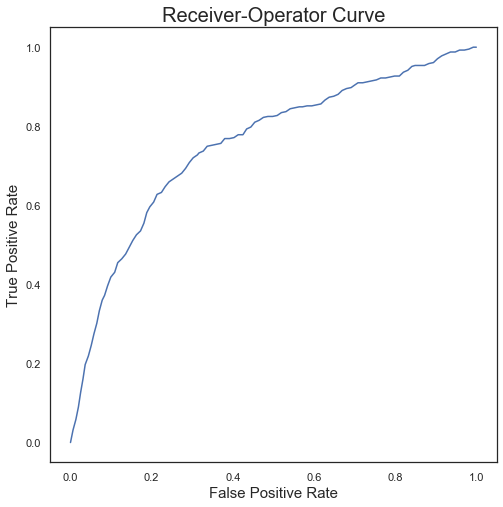

In [36]:
%local
ax, fig = plt.subplots(figsize=(8,8))
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Receiver-Operator Curve", fontsize=20)
plt.plot(roc["FPR"], roc["TPR"])

In [37]:
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

areaUnderROC: 0.7524318254245261

The closer to 1, the better. Here this is okay but not very high. Let's look at other metrics to know more about the performance of our model.

__Accuracy__

In [38]:
logRegPred = logRegModel.transform(labeled_train)
logRegPred.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[5.0,76.0,105.0,9...|    0|[1.75695906065571...|[0.85282839480790...|       0.0|
|[4.0,104.0,98.0,9...|    0|[1.81452344453469...|[0.85990768526919...|       0.0|
|[3.0,65.0,77.0,95...|    0|[1.36636776580648...|[0.79679267757174...|       0.0|
|[2.0,81.0,103.0,1...|    0|[2.87836280569230...|[0.94676640970571...|       0.0|
|[5.0,110.0,120.0,...|    0|[2.27073382255832...|[0.90642404878542...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

In [39]:
# obtain evaluator
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# compute the classification error on train data.
accuracy = evaluator.evaluate(logRegPred)
print("Training Accuracy = %g" %  accuracy)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Accuracy = 0.850852

We are not doing much better than a naive classifier!!! We could try to use different features and to do regularization.
Note : Model does not learn with regParam=0.3, elasticNetParam=0.8 (regularization strength is too high).

__Confusion matrix__

<img src="confusionMatrix.png" width=800/>

Sensitivity = TP / (TP + FN), also called Recall

Specificity = TN / (TN + FP)

Precision = TP / (TP + FP)

Negative Predictive Value = TN / (TN + FN)

F1-score: 2 x Precision x Recall / (Precision + Recall)

In [40]:
logRegPred.createOrReplaceTempView("logRegPred")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
%%sql -o logRegPred --maxrows -1
SELECT * FROM logRegPred

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [42]:
%local

# Confusion matrix

tn, fp, fn, tp = metrics.confusion_matrix(logRegPred["label"], logRegPred["prediction"]).ravel()
print(tn, fp, fn, tp)

2371 34 386 25


Comment: FN is too high! We are missing out many positive cases!

In [43]:
%local

# Metrics derived from the confusion matrix

from sklearn.metrics import classification_report

print(classification_report(logRegPred["label"], logRegPred["prediction"]))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2405
           1       0.42      0.06      0.11       411

    accuracy                           0.85      2816
   macro avg       0.64      0.52      0.51      2816
weighted avg       0.80      0.85      0.80      2816



Comment: ...

### c. Go a step further with Decision tree regression

In [44]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')
dt_model = dt.fit(labeled_train)
dt_predictions = dt_model.transform(labeled_train) #training error
dt_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = dt_evaluator.evaluate(dt_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data = 0.242838

In [45]:
# compute the classification error on train data for this new model
accuracy = evaluator.evaluate(dt_predictions)
print("Training Accuracy = %g" %  accuracy)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Accuracy = 0.0756392

In [46]:
# Feature importance
dt_model.featureImportances

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparseVector(11, {0: 0.0168, 1: 0.0055, 3: 0.0048, 4: 0.2082, 5: 0.0258, 6: 0.3847, 7: 0.2011, 8: 0.016, 9: 0.1371})

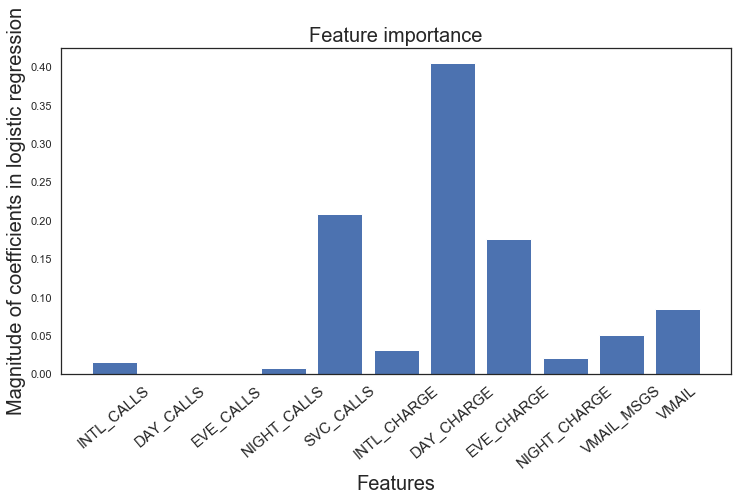

In [47]:
%local

#copy paste new coeffs list if necessary

features=["INTL_CALLS", "DAY_CALLS", "EVE_CALLS", "NIGHT_CALLS", "SVC_CALLS", 
          "INTL_CHARGE", "DAY_CHARGE", "EVE_CHARGE", "NIGHT_CHARGE",
          "VMAIL_MSGS", "VMAIL"]
coeffs=[0.0154, 0, 0, 0.0073, 0.2088, 0.0316, 0.4047, 0.1759, 0.0206, 0.0507, 0.085]

ax, fig=plt.subplots(figsize=(12,6))
index = np.arange(len(features))
plt.bar(index, coeffs)
plt.xlabel('Features', fontsize=20)
plt.ylabel('Magnitude of coefficients in logistic regression', fontsize=20)
plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance', fontsize=20)
plt.show()

### d. Gradient boosted tree regression  --> to remove (no learning??)

In [48]:
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label', maxIter=20)
gbt_model = gbt.fit(labeled_train)
gbt_predictions = gbt_model.transform(labeled_train)
gbt_predictions.select('prediction', 'label', 'features').show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+
|          prediction|label|            features|
+--------------------+-----+--------------------+
|0.009435996043782667|    0|[5.0,76.0,105.0,9...|
|0.013735689414303335|    0|[4.0,104.0,98.0,9...|
|  0.1076023722169982|    0|[3.0,65.0,77.0,95...|
|  0.0755433325908874|    0|[2.0,81.0,103.0,1...|
|0.007900515401776383|    0|[5.0,110.0,120.0,...|
+--------------------+-----+--------------------+
only showing top 5 rows

In [49]:
# compute the classification error on train data for this new model
accuracy = evaluator.evaluate(gbt_predictions)
print("Training Accuracy = %g" %  accuracy)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Accuracy = 0

In [50]:
gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data = 0.205016

Ideas for improvement ???

## 5. Fine tune your hyperparameters on the validation set

We will only do it for logistic regression, since it is the more promising model so far. A similar method can be applied for the other model types.

__Raw results__

In the following cell, default values are used for logistic regression's parameters. 

In [51]:
# Transform your validation set
assembled_val = LogReg_assembler.transform(val)

# Select only the label and features columns
labeled_val = assembled_val.select(assembled_val["features"], assembled_val["CHURN"].alias("label"))

# Make predictions
pred_val = logRegModel.transform(labeled_val)

# Define evaluator
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Compute the classification accuracy on the validation set
accuracy = evaluator.evaluate(pred_val)
print("Validation Accuracy = %g" %  accuracy)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Validation Accuracy = 0.885154

__Grid search__ Issue : improve accuracy... we should focus on FNR !

In the next cell we define a function to test a range of hyperparameters for regularization in order to improve accuracy.

class pyspark.ml.classification.LogisticRegression(self, featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=100, regParam=0.0, elasticNetParam=0.0, tol=1e-6, fitIntercept=True, threshold=0.5, thresholds=None, probabilityCol="probability", rawPredictionCol="rawPrediction", standardization=True, weightCol=None, aggregationDepth=2, family="auto")

In [52]:
def grid_search():
    """
    Input:
    DF : Spark Dataframe, prepared with features and label columns
    
    Output:
    best: dictionary with best hyperparameters and accuracies
    """
   
    # Define evaluator
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
    
    # Hyperparameter ranges
    regParam_range=[0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.8]
    elasticNetParam_range=[0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.8]
    
    # train_acc=[]
    # val_acc=[]
    best={"regParam":0, "elasticNetParam": 0, "training_accuracy": 0, "validation_accuracy": 0}
          
    for r in regParam_range:
        for e in elasticNetParam_range:
            
            print("regParam = "+str(r)+" , elasticNetParam = "+ str(e))
            
            # Define your model
            logReg = LogisticRegression(maxIter=100, regParam=r, elasticNetParam=e)

            # Fit the model on training set
            logRegModel = logReg.fit(labeled_train)

            # Make predictions
            pred_train = logRegModel.transform(labeled_train)
            pred_val = logRegModel.transform(labeled_val)

            # Compute the accuracy on both datasets
            t_a = evaluator.evaluate(pred_train)
            t_v = evaluator.evaluate(pred_val)
            print("Training Accuracy = %g" %  t_a)
            print("Validation Accuracy = %g" % t_v)
            print("")
            # train_acc.append(t_a)
            # val_acc.append(t_v)
            
            if t_v > best["validation_accuracy"]:
                best["regParam"] = r
                best["elasticNetParam"] = e
                best["training_accuracy"] = t_a
                best["validation_accuracy"] = t_v
                
    return best

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
grid_search()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

regParam = 0 , elasticNetParam = 0
Training Accuracy = 0.857599
Validation Accuracy = 0.879552

regParam = 0 , elasticNetParam = 0.01
Training Accuracy = 0.857599
Validation Accuracy = 0.879552

regParam = 0 , elasticNetParam = 0.05
Training Accuracy = 0.857599
Validation Accuracy = 0.879552

regParam = 0 , elasticNetParam = 0.1
Training Accuracy = 0.857599
Validation Accuracy = 0.879552

regParam = 0 , elasticNetParam = 0.2
Training Accuracy = 0.857599
Validation Accuracy = 0.879552

regParam = 0 , elasticNetParam = 0.4
Training Accuracy = 0.857599
Validation Accuracy = 0.879552

regParam = 0 , elasticNetParam = 0.8
Training Accuracy = 0.857599
Validation Accuracy = 0.879552

regParam = 0.01 , elasticNetParam = 0
Training Accuracy = 0.855469
Validation Accuracy = 0.879552

regParam = 0.01 , elasticNetParam = 0.01
Training Accuracy = 0.854048
Validation Accuracy = 0.885154

regParam = 0.01 , elasticNetParam = 0.05
Training Accuracy = 0.853338
Validation Accuracy = 0.876751

regParam = 

So we shall choose the following model : Logistic Regression with regParam set to 0.01 and elasticNetParam set to 0.1 We obtained a training accuracy of 0.852 and a validation accuracy of 0.914.

## 6. Assess your model performance on the test set

See what is the final perfomance of your tuned model on unseen data.

In [54]:
# Prepare the test set

# Transform your validation set
assembled_test = LogReg_assembler.transform(test)

# Select only the label and features columns
labeled_test = assembled_test.select(assembled_test["features"], assembled_test["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
# Define your model
logReg = LogisticRegression(maxIter=100, regParam=00.1, elasticNetParam=0.1)

# Fit the model on training set
logRegModel = logReg.fit(labeled_train)

# Make predictions on test set
pred_test = logRegModel.transform(labeled_test)

# Compute the accuracy on the test set
print("Test Accuracy = %g" %  evaluator.evaluate(pred_test))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy = 0.84375

## What you've learned

__Congratulations!__

Through this notebook, you've learned how to:
* ...

__Where to go from here?__

? ...

___
## Authors

Eva Feillet ...

__Licence__